# eq_IO_PR_sea_cycle: Zonal structure of the amplitude of the mean seasonal cycle of PR in the equatorial Indian Ocean

Computes the zonal root mean square error (RMSE) of of equatorial Pacific (50°E-110°E) amplitude (standard deviation) of the mean annual cycle (zonal 10°S-10°N average) precipitation (PR) between model and observations (the time averaging creates a 12 months mean annual cycle time series from which the standard deviation is computed)


## Datasets and reanalysis used for comparison

The following reference observational datasets are used to evaluate the model simulations:

- **GPCPv2.3 (1979-2018)**: The primary dataset for comparison. The Global Precipitation Climatology Project (GPCP) combines satellite and surface precipitation measurements to provide comprehensive global precipitation data.
  
Additional observational datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data, including precipitation, based on surface pressure observations and ensemble assimilation techniques.
- **CMAP (1979-2018)**: The CPC Merged Analysis of Precipitation (CMAP) is a blend of gauge and satellite observations, offering global precipitation estimates.
- **ERA-Interim (1979-2018)**: Reanalysis data produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), providing atmospheric variables, including precipitation, based on a large-scale model and historical observations.
- **NCEP2 (1979-2018)**: The second generation of the National Centers for Environmental Prediction (NCEP) reanalysis, offering precipitation and other atmospheric variables.

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/distributed/node.py:168: ResourceWarning: unclosed <socket.socket fd=61, family=2, type=1, proto=6, laddr=('0.0.0.0', 0)>
  if retries_left < 1:
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36481 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36481/status,
Dashboard: /proxy/36481/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43353,Workers: 7
Dashboard: /proxy/36481/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:34145,Total threads: 1
Dashboard: /proxy/43405/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:35133,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/myproxy/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').declare_namespace(__name__)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('logilab')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/pkg_resources/__init__.py:3117: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is pr

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2),
# "NOAA-CIRES-20CR-V2": 
#     Dataset(
#     short_name='pr',
#     dataset='NOAA-CIRES-20CR-V2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="187101/201212",
#     tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2),
## ERA-Interim not available in Tier2. Conctact NRI
# "ERA-Interim": 
#     Dataset(
#     short_name='pr',
#     dataset='ERA-Interim',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [6]:
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [7]:
def prepoc1(cube):
    nino3_ep_region = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator='mean', period='monthly')
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed(['month_number'], iris.analysis.STD_DEV)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_ep_region)   
    cube = axis_statistics(cube, operator="mean", axis="y")
    return cube

def prepoc2(cube):
    nino3_latext_region = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -25., "end_latitude": 25.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator='mean', period='monthly')
    cube.coord('month_number').guess_bounds()
    cube = cube.collapsed(['month_number'], iris.analysis.STD_DEV)
    cube = convert_units(cube, units="mm/day")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    return cube

In [8]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

# Diagnostics Level 1


In [9]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


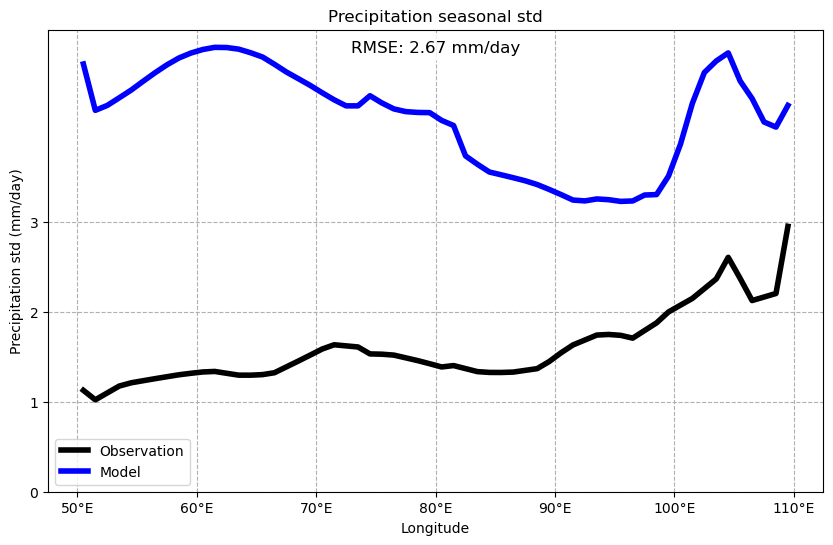

In [10]:
plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["GPCP-SG"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Precipitation std (mm/day)')
plt.title('Precipitation seasonal std')
plt.grid(linestyle='--')
plt.yticks(np.arange(0,4, step=1))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} mm/day', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the amplitude of the mean seasonal cycle of precipitation (PR) in the equatorial Indian Ocean (averaged between 10°S–10°N). The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


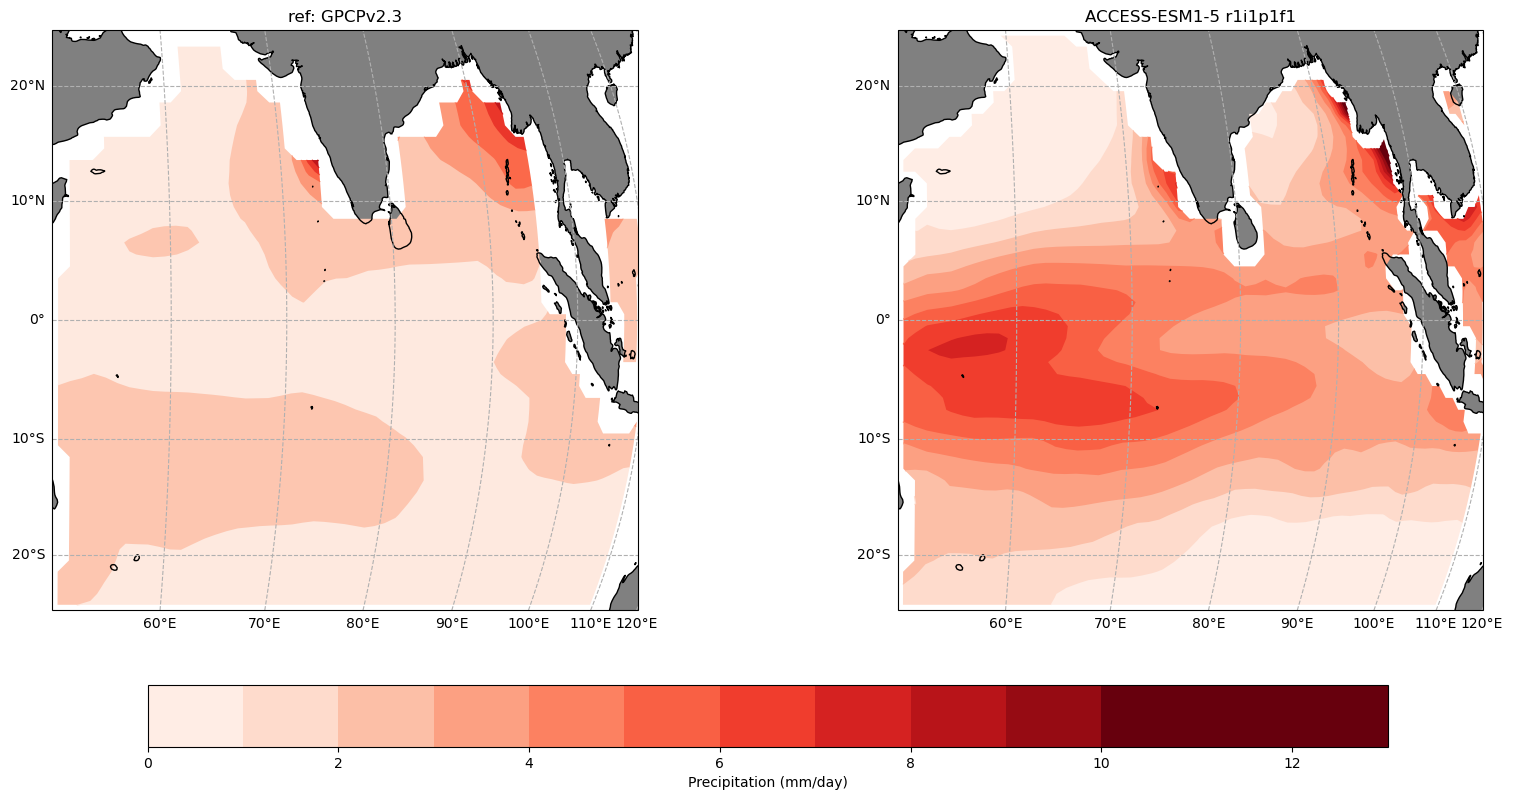

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('Reds')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=50, central_latitude=0)
norm = mcolors.Normalize()

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([50, 110, -25, 25], crs=ccrs.PlateCarree())
ax1.set_title("ref: GPCPv2.3")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm,levels=np.arange(0,14))
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([50, 110, -25, 25], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('Precipitation (mm/day)')
#cbar.set_ticks(np.arange(0, 5, 1))  # Set ticks at intervals of 2 mm

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Bias in the amplitude of the mean seasonal cycle of precipitation (PR) in the equatorial Indian Ocean. The left map displays the reference data, while the right map shows the model data.

# Diagnostic Level 3

The third level shows the zonal structure of the mean seasonal cycle in a Hovmöller diagram (picking the Western IO box as it shows the largest difference)

In [23]:
from esmvalcore.preprocessor import axis_statistics


def preproc3(cube):
    eq_region = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="monthly")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **eq_region)
    cube = axis_statistics(cube, axis="y", operator='mean')
    return cube

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}
process = {**model_datasets_prep3, **obs_datasets_prep3}

In [24]:
process

{'ACCESS-ESM1-5': <iris 'Cube' of lwe_precipitation_rate / (mm/day) (month_number: 12; longitude: 20)>,
 'GPCP-SG': <iris 'Cube' of lwe_precipitation_rate / (mm/day) (month_number: 12; longitude: 20)>}

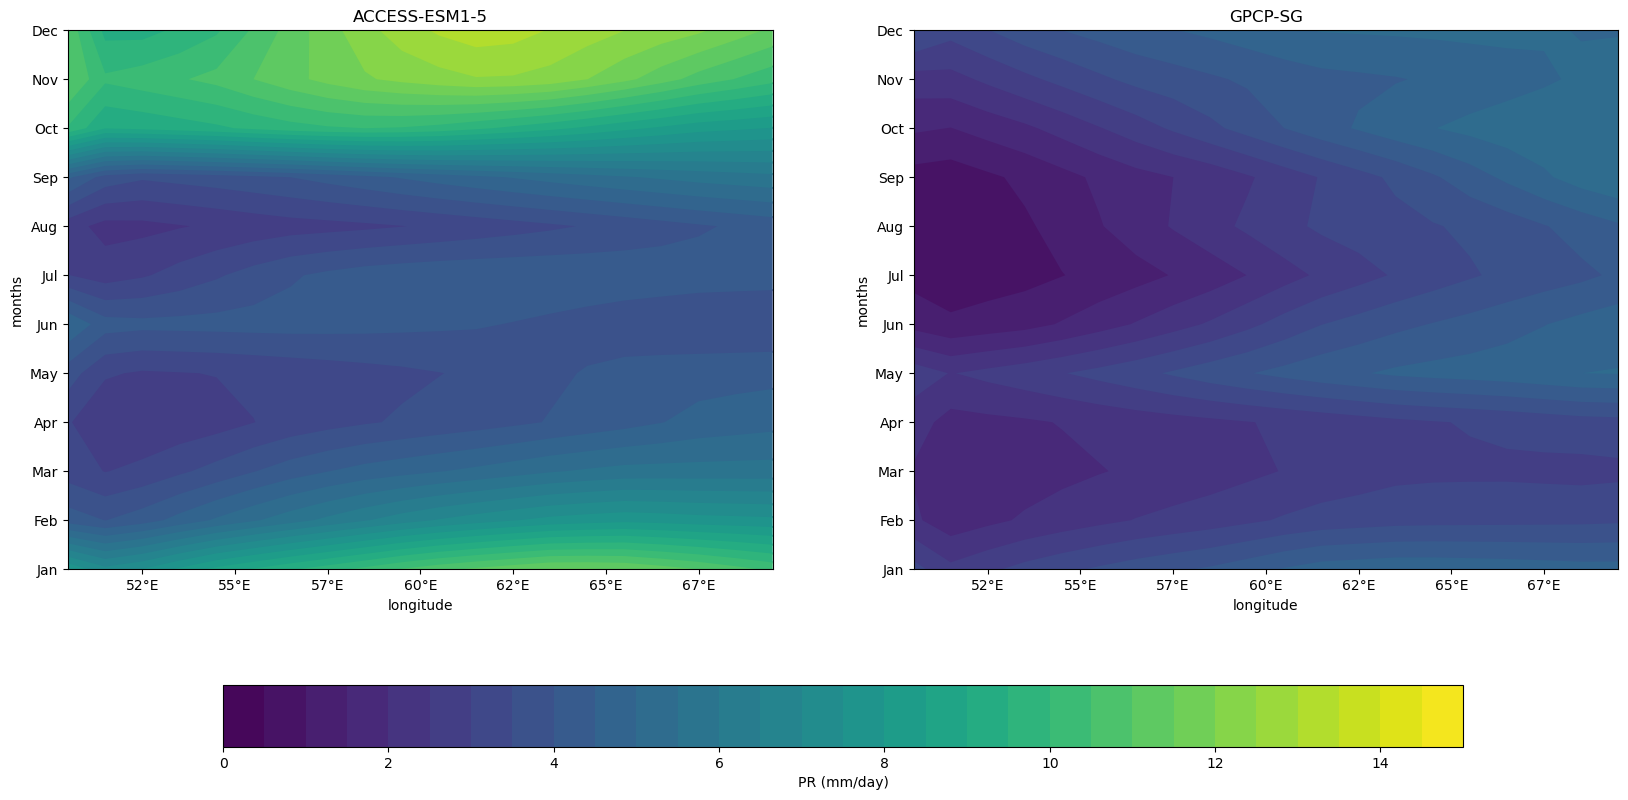

In [25]:
fig = plt.figure(figsize=(20, 10))
i=121

# Define tick positions and labels for the y-axis (months)
month_ticks = np.arange(1, 13, 1)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axls =[]
for label, cube in process.items():
    
    ax1 = plt.subplot(i)
    cf1 = iplt.contourf(cube,coords=['longitude','month_number'],levels=np.arange(0,15.5,0.5),cmap="viridis")
    ax1.set_ylim(1, 12)
    ax1.set_yticks(ticks=month_ticks, labels=month_labels)
    ax1.set_title(label)
    ax1.set_ylabel("months")
    ax1.set_xlabel("longitude")
    axls.append(ax1)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
    i+=1

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf1, ax=axls, orientation='horizontal',shrink=0.8, extend='both')
cbar.set_label('PR (mm/day)')

Figure 3: zonal structure of the mean seasonal cycle of precipitation (PR) in the western Indian Ocean (10°S-10°N averaged). The left and right maps show respectively the reference and the model